In [ ]:
!pip install python-dotenv
!pip install kaggle

In [ ]:
from google.colab import drive
from pathlib import Path
import subprocess
import torch
from IPython.display import Image  # for displaying images
import os 
import random
import shutil
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET
from xml.dom import minidom
from tqdm import tqdm
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path 
from dotenv import load_dotenv
load_dotenv()
from src.utils import download_data_file, KaggleDownloader
import yaml
import matplotlib.pyplot as plt
%matplotlib inline
import cv2

random.seed(108)

In [ ]:
torch.__version__

'1.9.0+cu111'

In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0


In [ ]:
torch.cuda.device_count()

1

In [ ]:
torch.cuda.current_device() 

0

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
download_data_file(
    url="arkadiyhacks/drinking-waste-classification",
    dest="./waste_data",
    clz=KaggleDownloader,
    extract=True
)

Using KaggleDownloader to download arkadiyhacks/drinking-waste-classification to ./waste_data


In [ ]:
download_data_file(
    url="techsash/waste-classification-data",
    dest="./waste_data",
    clz=KaggleDownloader,
    extract=True
)

Using KaggleDownloader to download techsash/waste-classification-data to ./waste_data


In [ ]:
commands = ['git clone https://github.com/ultralytics/yolov5', 'pip install -r yolov5/requirements.txt']
for command in commands: 
  subprocess.call(command.split())

In [ ]:
imgs = []
annot = []
dir = 'waste_data/Images_of_Waste/YOLO_imgs'
for file in os.listdir(dir): 
  if "jpg" in file:
    image_name_path = os.path.splitext(file)[0]
    annot_path = image_name_path + ".txt"
    if os.path.exists(os.path.join(dir,file)):
      if os.path.exists(os.path.join(dir,annot_path)):
        imgs.append(os.path.join(dir,file))
        annot.append(os.path.join(dir,annot_path))

In [ ]:
imgs.sort()
annot.sort()
print("Size of image data: ", len(imgs))
print("Size of annotation data: ", len(annot))

Size of image data:  4811
Size of annotation data:  4811


In [ ]:
print("Image list: ", imgs[:3])

Image list:  ['waste_data/Images_of_Waste/YOLO_imgs/AluCan1,000.jpg', 'waste_data/Images_of_Waste/YOLO_imgs/AluCan1,001.jpg', 'waste_data/Images_of_Waste/YOLO_imgs/AluCan1,002.jpg']


In [ ]:
print("Annotation list: ", annot[:3])

Annotation list:  ['waste_data/Images_of_Waste/YOLO_imgs/AluCan1,000.txt', 'waste_data/Images_of_Waste/YOLO_imgs/AluCan1,001.txt', 'waste_data/Images_of_Waste/YOLO_imgs/AluCan1,002.txt']


In [ ]:
for file in annot: 
  file_handler = open(file, 'r')
  lines = file_handler.readlines()
  new_lines = []
  for line in lines: 
    new_class_label = '0' + line[1:]
    new_lines.append(new_class_label)
  file_handler.close()
  file_handler = open(file, 'w')
  for line in new_lines: 
    file_handler.writelines(line + '\n')


In [ ]:
train_data, val_data, train_annot, val_annot = train_test_split(imgs, annot, test_size = 0.2, random_state = 42)
val_data, test_data, val_annot, test_annot = train_test_split(val_data, val_annot, test_size = 0.5, random_state = 42)


In [ ]:
folders = ['waste_data/images', 'waste_data/labels']
for folder in folders:
  if os.path.exists(folder):
    shutil.rmtree(folder) 
  os.mkdir(folder)

In [ ]:
# Below code was partially taken from https://blog.paperspace.com/train-yolov5-custom-data/

def move_files_to_folder(list_of_files, destination_folder):
  if not os.path.exists(destination_folder):
    os.mkdir(destination_folder)
  for f in list_of_files:
      shutil.move(f, destination_folder)

# Above code was partially taken from https://blog.paperspace.com/train-yolov5-custom-data/

In [ ]:
# Below code was partially taken from https://blog.paperspace.com/train-yolov5-custom-data/
move_files_to_folder(train_data, 'waste_data/images/train')
move_files_to_folder(val_data, 'waste_data/images/val/')
move_files_to_folder(test_data, 'waste_data/images/test/')
move_files_to_folder(train_annot, 'waste_data/labels/train/')
move_files_to_folder(val_annot, 'waste_data/labels/val/')
move_files_to_folder(test_annot, 'waste_data/labels/test/')
# Above code was partially taken from https://blog.paperspace.com/train-yolov5-custom-data/

In [ ]:
org_train_dir = './waste_data/dataset/DATASET/TRAIN/O'
org_test_dir = './waste_data/dataset/DATASET/TEST/O'
organic_train_class_files = [os.path.join(org_train_dir, file) for file in os.listdir(org_train_dir)]
organic_test_class_files = [os.path.join(org_test_dir, file) for file in os.listdir(org_test_dir)]
move_files_to_folder(organic_train_class_files, 'waste_data/images/train/')
move_files_to_folder(organic_test_class_files, 'waste_data/images/test/')

In [ ]:
#FIX THIS
# data = dict(
#     train = "../../images/train",
#     val = "../../images/val", 
#     test = "../../images/test", 
#     nc = 4, 
#     names = ["alumninum", "glass", "pet", "hdpe"]
# )

# with open('yolov5/data/waste-class.yml', 'w') as outfile:
#     yaml.dump(data, outfile)


In [ ]:
!python yolov5/train.py --img 700 --cfg yolov5s.yaml --hyp hyp.scratch.yaml --batch 32 --epochs 20 --data waste-class.yaml --weights yolov5s.pt --workers 24 --name yolo_waste_det --device 0

train: weights=yolov5s.pt, cfg=yolov5s.yaml, data=waste-class.yaml, hyp=hyp.scratch.yaml, epochs=20, batch_size=32, imgsz=700, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, evolve=None, bucket=, cache=None, image_weights=False, device=0, multi_scale=False, single_cls=False, adam=False, sync_bn=False, workers=24, project=yolov5/runs/train, name=yolo_waste_det, exist_ok=False, quad=False, linear_lr=False, label_smoothing=0.0, patience=100, freeze=0, save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: skipping check (not a git repository), for updates see https://github.com/ultralytics/yolov5
YOLOv5 🚀 v6.0-35-ga4fece8 torch 1.9.0+cu111 CUDA:0 (Tesla P100-PCIE-16GB, 16280.875MB)

hyperparameters: lr0=0.01, lrf=0.1, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hs

In [ ]:
!python ./yolov5/detect.py  --img 700 --source /content/waste_data/images/test/ --weights yolov5/runs/train/yolo_waste_det/weights/best.pt --conf 0.25 --name yolo_waste_det

detect: weights=['yolov5/runs/train/yolo_waste_det/weights/best.pt'], source=/content/waste_data/images/test/, imgsz=[700, 700], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=yolov5/runs/detect, name=yolo_waste_det, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.0-35-ga4fece8 torch 1.9.0+cu111 CUDA:0 (Tesla P100-PCIE-16GB, 16280.875MB)

Fusing layers... 
Model Summary: 213 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
image 1/1883 /content/waste_data/images/test/AluCan1,017.jpg: 704x544 1 recycalable, Done. (0.012s)
image 2/1883 /content/waste_data/images/test/AluCan1,031.jpg: 704x544 1 recycalable, Done. (0.007s)
image 3/1883 /content/waste_data/images/test/AluCan1,047.jpg: 704x544 1 recycalable, Done. (0.007s)
image 4/1883 /content/waste_data/ima

In [51]:
# random photo from the internet 
!python ./yolov5/detect.py  --img 700 --source /content/waste_data/images/random/ --weights yolov5/runs/train/yolo_waste_det/weights/best.pt --conf 0.1 --name yolo_waste_det325

detect: weights=['yolov5/runs/train/yolo_waste_det/weights/best.pt'], source=/content/waste_data/images/random/, imgsz=[700, 700], conf_thres=0.1, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=yolov5/runs/detect, name=yolo_waste_det325, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.0-35-ga4fece8 torch 1.9.0+cu111 CUDA:0 (Tesla P100-PCIE-16GB, 16280.875MB)

Fusing layers... 
Model Summary: 213 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
image 1/4 /content/waste_data/images/random/285658852.jpg: 544x704 Done. (0.013s)
image 2/4 /content/waste_data/images/random/328057_o03_111120.jpg: 704x704 1 recycalable, Done. (0.009s)
image 3/4 /content/waste_data/images/random/AluCan1,017.jpg: 704x544 1 recycalable, Done. (0.015s)
image 4/4 /content/waste_data/images/random/tr

['yolov5/runs/detect/yolo_waste_det325/285658852.jpg', 'yolov5/runs/detect/yolo_waste_det325/328057_o03_111120.jpg', 'yolov5/runs/detect/yolo_waste_det325/AluCan1,017.jpg', 'yolov5/runs/detect/yolo_waste_det325/trash-talk-5-food-scraps-you-should-not-be-throwing-away.w1456.jpg']


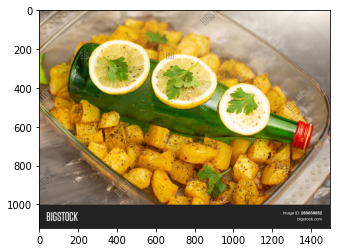

In [52]:
detect_dir = "yolov5/runs/detect/yolo_waste_det325"
detect_images = [os.path.join(detect_dir, x) for x in os.listdir(detect_dir)]
print(detect_images)
img_0 = Image.open(detect_images[0])
img_1 = Image.open(detect_images[1])
img_2 = Image.open(detect_images[2])
img_3 = Image.open(detect_images[3])
plt.imshow(np.array(img_0))


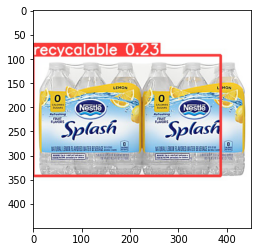

In [53]:
plt.imshow(np.array(img_1))

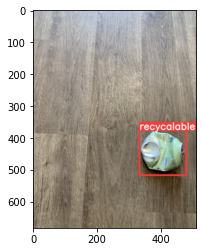

In [54]:
plt.imshow(np.array(img_2))

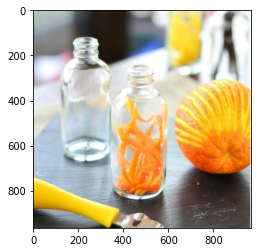

In [55]:
plt.imshow(np.array(img_3))

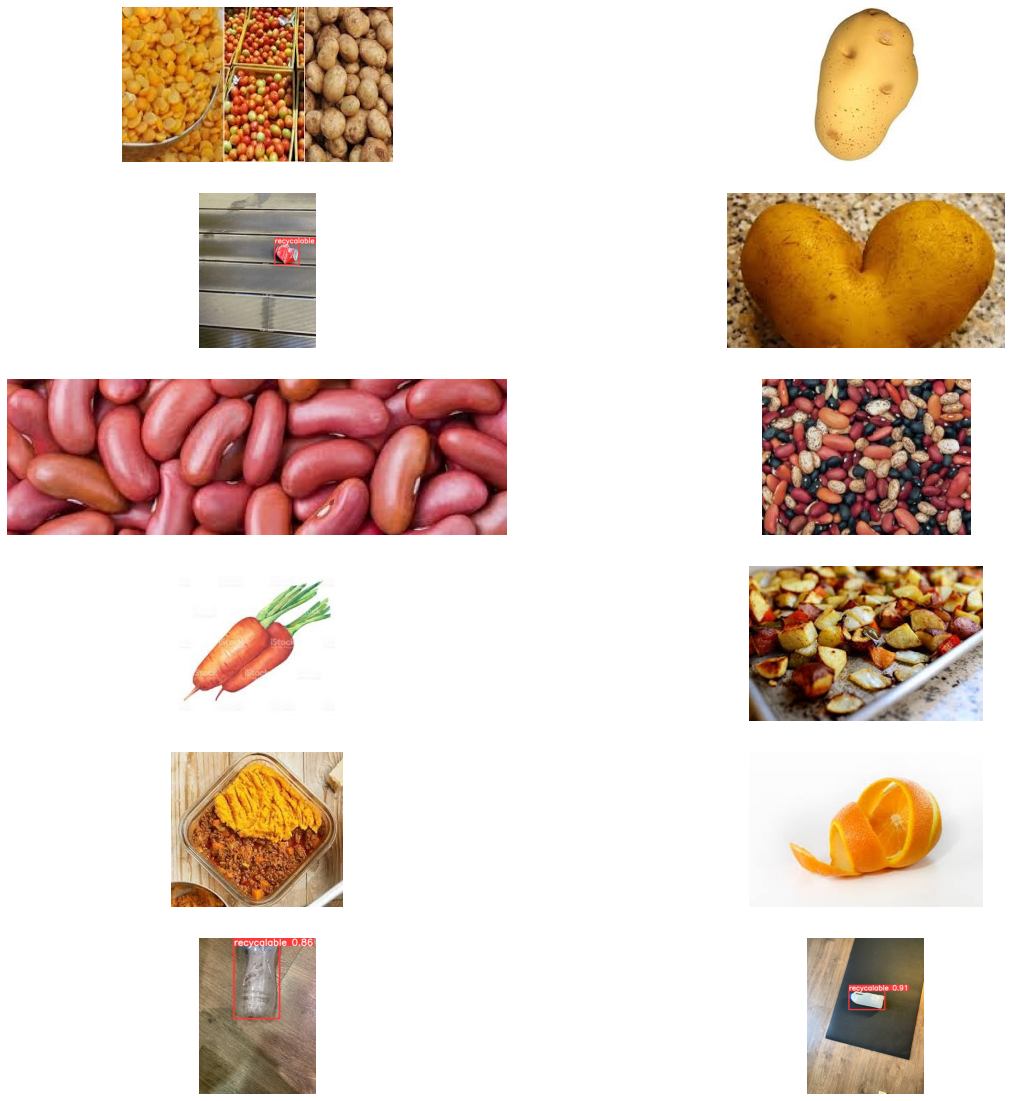

In [ ]:
# Code taken from APCOMP 215 tutorial 04_tutorial_model_compression
image_samples = np.random.randint(0,high=len(detect_images)-1, size=12)

# View some images
fig = plt.figure(figsize=(20,20))
for i,img_idx in enumerate(image_samples):
    axs = fig.add_subplot(6,2,i+1)
    # Read image
    image = cv2.imread(detect_images[img_idx])
    # convert to rgb
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.axis('off')

plt.show()
# Code taken from APCOMP 215 tutorial 04_tutorial_model_compression